# **Step-1:** Data Pre-processing

In [3]:
# Load dataset and review it
import pandas as pd

data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Handling missing values (numerical missing values will replace with the median and categorical missing values with the mode)
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

data[num_cols] = data[num_cols].fillna(data[num_cols].median())
data[cat_cols] = data[cat_cols].fillna(data[cat_cols].mode().iloc[0])

# Encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# Check if there are any missing values left
data.isnull().sum().sum()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


0

#**Step-2:** EDA

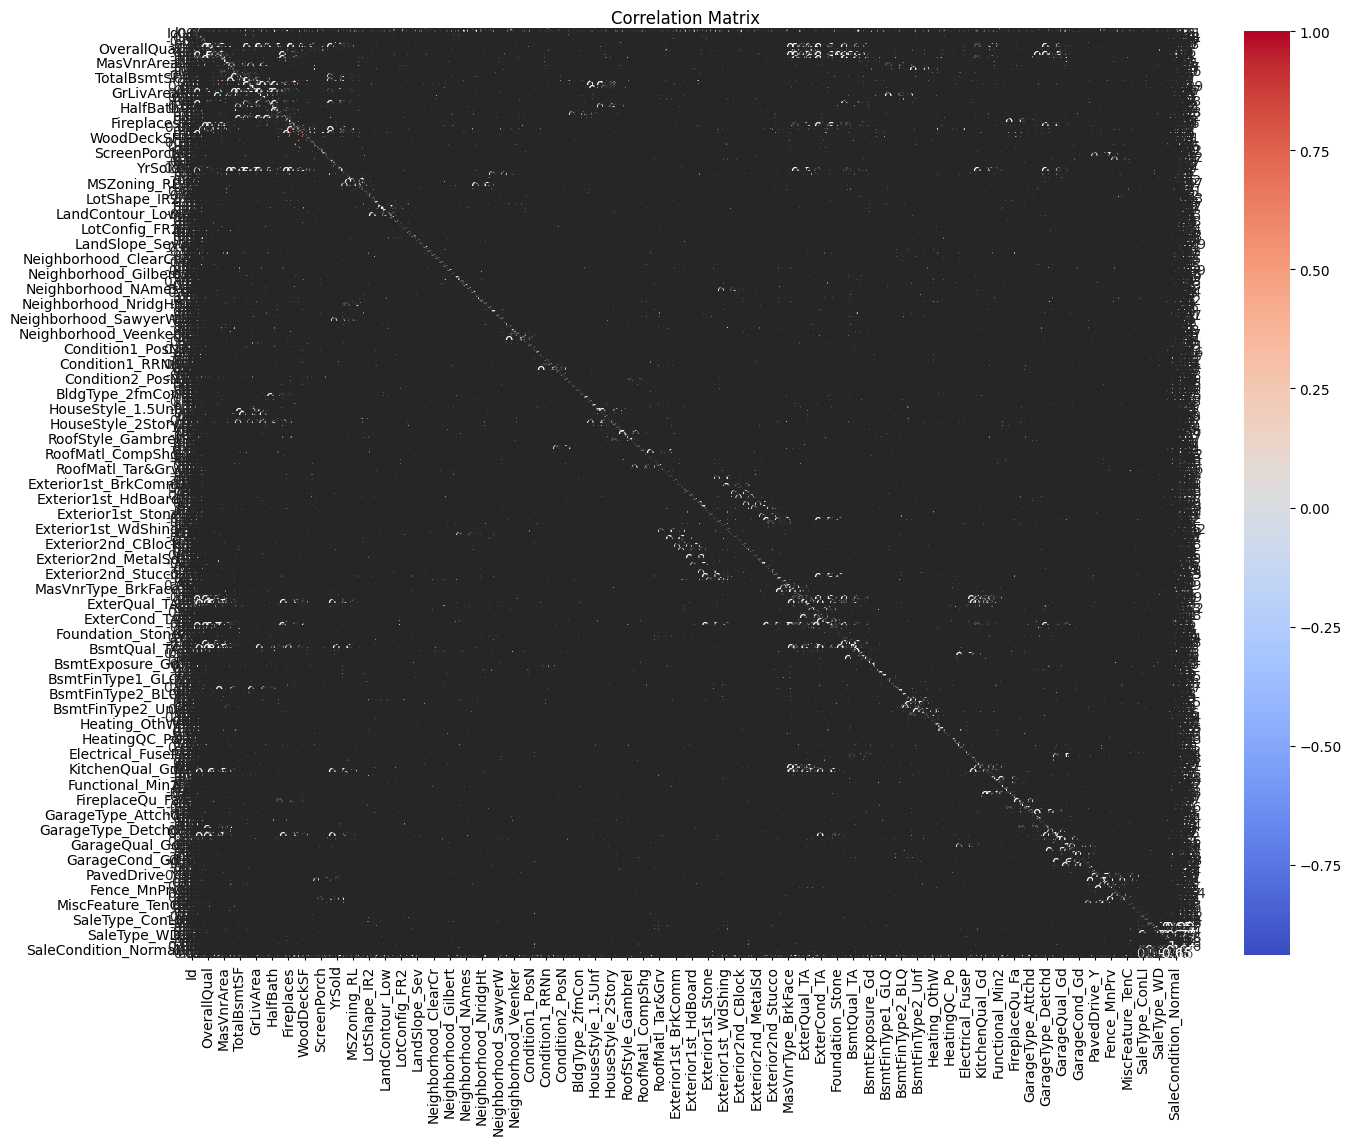

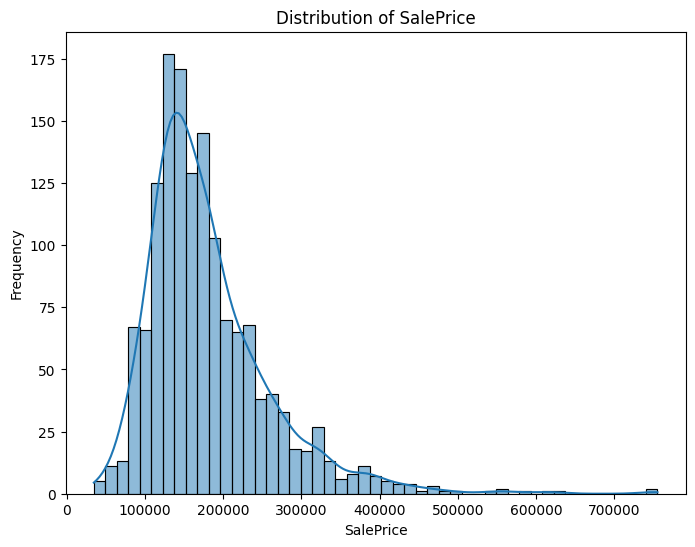

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(data['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# **Step-3:** Model Building

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Split the data into features and target variable
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ridge regression
ridge = Ridge()
parameters = {'alpha': [0.1, 1, 10, 100, 200, 300, 400, 500, 1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)

# Best alpha for Ridge
best_alpha_ridge = ridge_regressor.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge}")

# Lasso regression
lasso = Lasso()
parameters = {'alpha': [0.1, 1, 10, 100, 200, 300, 400, 500, 1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

# Best alpha for Lasso
best_alpha_lasso = lasso_regressor.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha_lasso}")

Best alpha for Ridge: 500


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+11, tolerance: 5.374e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+11, tolerance: 5.720e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e+11, tolerance: 5.256e

Best alpha for Lasso: 1000


# **Step-4:** Model Evaluation

In [9]:
# Ridge regression with the best alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_rmse = mean_squared_error(y_test, ridge_predictions, squared=False)
print(f"Ridge Regression RMSE: {ridge_rmse}")

# Lasso regression with the best alpha
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_rmse = mean_squared_error(y_test, lasso_predictions, squared=False)
print(f"Lasso Regression RMSE: {lasso_rmse}")

# Identifying significant variables
ridge_coefficients = pd.Series(ridge_model.coef_, index=X.columns)
lasso_coefficients = pd.Series(lasso_model.coef_, index=X.columns)

# Displaying significant variables for Ridge
significant_ridge_vars = ridge_coefficients[ridge_coefficients != 0]
print("Significant variables in Ridge Regression:\n", significant_ridge_vars)

# Displaying significant variables for Lasso
significant_lasso_vars = lasso_coefficients[lasso_coefficients != 0]
print("Significant variables in Lasso Regression:\n", significant_lasso_vars)

Ridge Regression RMSE: 32947.04413005576
Lasso Regression RMSE: 30969.7294141506
Significant variables in Ridge Regression:
 Id                       -663.061178
MSSubClass              -3024.884648
LotFrontage              -216.328494
LotArea                  2851.087470
OverallQual              8741.890584
                            ...     
SaleCondition_AdjLand     171.049727
SaleCondition_Alloca     1691.000764
SaleCondition_Family     -658.855108
SaleCondition_Normal      197.386946
SaleCondition_Partial    2071.105619
Length: 243, dtype: float64
Significant variables in Lasso Regression:
 MSSubClass               -7345.282871
LotFrontage               -433.379455
LotArea                   3316.525327
OverallQual              16277.939055
OverallCond               3885.359722
                             ...     
Fence_MnPrv                198.975895
MiscFeature_TenC           -21.088542
SaleType_Con               109.345540
SaleCondition_Alloca       690.651687
SaleCondition_Pa